In [1]:
import pandas as pd
import seaborn as sns

In [2]:
import re

In [3]:
Base500Canciones = pd.read_csv('dataset/Top 500 Songs.csv', encoding = 'latin1')

In [4]:
Base500Canciones['Fecha de Estreno'] = pd.to_datetime(Base500Canciones['released'])

###### ¿Qué dicen sobre estas canciones?

###### ¿Existen grupos de criticos?

In [5]:
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

from sklearn.decomposition import NMF

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://num

In [6]:

def preprocess(text,stem = False):
    
    stop_words = stopwords.words("english")
    stemmer = SnowballStemmer("english")

    TEXT_CLEANING_RE = '\d+|-|_|°|/|\)|\(|\!|\?|\¡|\¿|\.|\|º|,|"'
    
    def normalize(s):
        replacements = (
            ("á", "a"),
            ("é", "e"),
            ("í", "i"),
            ("ó", "o"),
            ("ú", "u"),
        )
        for a, b in replacements:
            s = s.replace(a, b).replace(a.upper(), b.upper())
        return s

    
    # Romeviendo caracteres especiales
    text = re.sub(TEXT_CLEANING_RE, ' ', 
                  normalize(
                      str(text)
                  )
                  .lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    
    return " ".join(tokens)

In [7]:
Base500Canciones['description prepocess'] = Base500Canciones.description.apply(lambda y: preprocess(y))

In [8]:
Base500Canciones['description prepocess stem'] = Base500Canciones.description.apply(lambda y: preprocess(y))

### Conteo de palabras

In [9]:
ModeloPalabras = CountVectorizer(min_df=0.01, max_df=0.3)

In [10]:
ModeloPalabras.fit(Base500Canciones['description prepocess'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.3, max_features=None, min_df=0.01,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [11]:
(
pd.DataFrame(
    ModeloPalabras.transform(Base500Canciones['description prepocess']).todense()
    , columns = ModeloPalabras.get_feature_names()
    , index = Base500Canciones.index)
    .join(Base500Canciones['Fecha de Estreno'])
    .groupby(pd.Grouper(key = 'Fecha de Estreno', freq = '10Y'))
    .sum()
    .apply(lambda y: y/sum(y), axis = 1)
    .apply(lambda y: y.nlargest(3).index, axis = 1)
)

Fecha de Estreno
1906-12-31     Index(['crazy', 'radio', 'pop'], dtype='object')
1916-12-31     Index(['one', 'ballad', 'band'], dtype='object')
1926-12-31                            Index([], dtype='object')
1936-12-31                            Index([], dtype='object')
1946-12-31                            Index([], dtype='object')
1956-12-31    Index(['presley', 'first', 'blues'], dtype='ob...
1966-12-31       Index(['first', 'one', 'hit'], dtype='object')
1976-12-31     Index(['one', 'wrote', 'first'], dtype='object')
1986-12-31         Index(['one', 'hit', 'new'], dtype='object')
1996-12-31      Index(['like', 'one', 'songs'], dtype='object')
2006-12-31       Index(['like', 'hit', 'band'], dtype='object')
2016-12-31    Index(['says', 'brothers', 'career'], dtype='o...
Freq: 10A-DEC, dtype: object

¿Contar las palabras es una buena forma de extraer información?

###### Tf idf

In [12]:
ModeloPalabrasTf = TfidfVectorizer(min_df=0.1, max_df=0.75, ngram_range=(1,3))

In [13]:
ModeloPalabrasTf.fit(Base500Canciones['description prepocess'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.75, max_features=None,
                min_df=0.1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [14]:
(
pd.DataFrame(
    ModeloPalabrasTf.transform(Base500Canciones['description prepocess']).todense()
    , columns = ModeloPalabrasTf.get_feature_names()
    , index = Base500Canciones.index)
    .join(Base500Canciones['Fecha de Estreno'])
    .groupby(pd.Grouper(key = 'Fecha de Estreno', freq = '10Y'))
    .mean()
    .apply(lambda y: y.nlargest(3).index, axis = 1)
)

Fecha de Estreno
1906-12-31     Index(['pop', 'rock', 'studio'], dtype='object')
1916-12-31     Index(['one', 'studio', 'band'], dtype='object')
1926-12-31                            Index([], dtype='object')
1936-12-31                            Index([], dtype='object')
1946-12-31                            Index([], dtype='object')
1956-12-31    Index(['first', 'song', 'recorded'], dtype='ob...
1966-12-31     Index(['song', 'said', 'first'], dtype='object')
1976-12-31     Index(['said', 'song', 'wrote'], dtype='object')
1986-12-31       Index(['said', 'one', 'song'], dtype='object')
1996-12-31      Index(['said', 'song', 'like'], dtype='object')
2006-12-31      Index(['said', 'song', 'like'], dtype='object')
2016-12-31       Index(['said', 'hit', 'song'], dtype='object')
Freq: 10A-DEC, dtype: object

### Clasificando comentarios

Vectorizando palabras

In [15]:
ModeloPalabrasTfStem = TfidfVectorizer(min_df=0.1, max_df=0.75, ngram_range=(1,3))

In [16]:
ModeloPalabrasTfStem.fit(Base500Canciones['description prepocess stem'])
VectorTfidf = ModeloPalabrasTfStem.transform(Base500Canciones['description prepocess stem'])

Reduciendo dimensiones

In [17]:
from sklearn.decomposition import PCA, NMF

In [18]:
a = PCA().fit(VectorTfidf.todense())

In [21]:
PruebasNMF = [(n_c,NMF(n_components=n_c).fit(VectorTfidf).reconstruction_err_) for n_c in range(1,50)]

<AxesSubplot:>

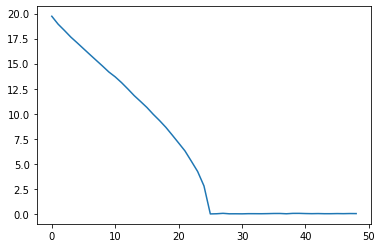

In [23]:
pd.DataFrame(PruebasNMF, columns = ['N','Error'])['Error'].plot()

In [24]:
ModeloNMF = NMF(n_components=25)

In [25]:
ModeloNMF.fit(VectorTfidf),

(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
     n_components=25, random_state=None, shuffle=False, solver='cd', tol=0.0001,
     verbose=0),)

In [26]:
pd.DataFrame(ModeloNMF.components_, columns = ModeloPalabrasTfStem.get_feature_names()).transpose().apply(lambda y: y.nlargest(10).index)

0       1       2       3       4       5       6         7       8   \
0    song    said    like     one   wrote  guitar     new       hit    rock   
1    told     one  guitar  number     one    band    band    number  guitar   
2    band  single    told   would    rock  became  became  recorded    told   
3  became  studio     cut    band    band    came    came       cut    band   
4    came    band    band  became  became     cut     cut      band  became   
5     cut  became  became    came    came   first   first    became    came   
6   first    came    came     cut     cut     got     got      came     cut   
7     got     cut   first   first   first     hit  guitar     first   first   
8  guitar   first     got     got     got   later     hit       got     got   
9     hit     got     hit  guitar  guitar    like   later    guitar     hit   

       9   ...        15      16        17        18        19       20  \
0  studio  ...   version  lyrics     later     would  recorded      pop   
1    band  ...    single  number       one    single      song   number   
2  became  ...       one    band    single      song    record  version   
3    came  ...       hit  became    became    record      rock    would   
4     cut  ...  recorded    came       pop  recorded      band     band   
5   first  ...      band     cut    lyrics      band    became   became   
6     got  ...    became   first       hit    became      came     came   
7  guitar  ...      came     got      song      came       cut      cut   
8     hit  ...       cut  guitar  recorded       cut     first    first   
9   later  ...     first     hit    guitar     first       got      got   

       21      22      23        24  
0   first  record  single    became  
1  studio    song  number    number  
2    band  studio   wrote      song  
3  became    band   first      said  
4    came  became    like  recorded  
5     cut    came  guitar       new  
6     got     cut  studio    guitar  
7  guitar   first    band      band  
8     hit     got  became      came  
9   later  guitar    came       cut  

[10 rows x 25 columns]

Dimension 1: Menciones a la cancion/hits
Dimensión 2: Declaraciones a la revista rolling stone
Dimension 3: Mención a The Beatles

In [27]:


pd.DataFrame(
    ModeloNMF.transform(VectorTfidf),
    index = Base500Canciones.index,
    #columns = ['Canciones','Declaraciones','Beatles']

)


0         1         2         3         4         5         6   \
0    0.051661  0.145793  0.205586  0.000000  0.175509  0.000000  0.000000   
1    0.000000  0.000007  0.000000  0.200177  0.000047  0.000000  0.000000   
2    0.056364  0.000007  0.000000  0.190623  0.191531  0.000000  0.000000   
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4    0.029359  0.000000  0.000000  0.119115  0.099691  0.000000  0.092673   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.058863  0.166114  0.234240  0.000000  0.000000  0.000000  0.000000   
496  0.056520  0.159502  0.000000  0.000000  0.000000  0.000000  0.178404   
497  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
498  0.106604  0.100284  0.141415  0.000000  0.000000  0.149312  0.000000   
499  0.045455  0.000004  0.000000  0.152200  0.000036  0.000000  0.000000   

           7    8         9   ...        15        16        17   18  \
0    0.000000  0.0  0.000000  ...  0.000000  0.000000  0.000000  0.0   
1    0.000000  0.0  0.000000  ...  0.000023  0.229139  0.000146  0.0   
2    0.000000  0.0  0.000000  ...  0.000023  0.219349  0.000142  0.0   
3    0.000000  0.0  0.000000  ...  0.000000  0.000000  0.000000  0.0   
4    0.088724  0.0  0.119993  ...  0.000000  0.001774  0.000000  0.0   
..        ...  ...       ...  ...       ...       ...       ...  ...   
495  0.000000  0.0  0.000000  ...  0.000000  0.230454  0.000000  0.0   
496  0.000000  0.0  0.230996  ...  0.000000  0.000000  0.000000  0.0   
497  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.000000  0.0   
498  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.176129  0.0   
499  0.000000  0.0  0.000000  ...  0.000010  0.176859  0.225469  0.0   

               19        20        21   22        23            24  
0    1.971739e-01  0.000000  0.000000  0.0  0.000000  7.864770e-13  
1    0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00  
2    0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00  
3    0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00  
4    1.120538e-01  0.001855  0.180946  0.0  0.138705  5.023549e-03  
..            ...       ...       ...  ...       ...           ...  
495  2.237304e-22  0.000000  0.000000  0.0  0.000000  0.000000e+00  
496  2.005654e-22  0.000000  0.000000  0.0  0.000000  1.100536e-13  
497  0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00  
498  0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00  
499  0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00  

[500 rows x 25 columns]

###### Segmentando

In [28]:
from sklearn.cluster import KMeans

###### Evaluando n clusters

In [29]:
import matplotlib.pyplot as plt

In [30]:
ModelosCluster = [KMeans(n_clusters=i) for i in range(1,30)]

In [32]:
from sklearn.metrics import silhouette_score

In [40]:
# determine optimal number of clusters using silhouette analysis
sil_scores = []
k_range = range(2, 50, 1)
X = ModeloNMF.transform(VectorTfidf)
for k in k_range:
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

2
3
4


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

5
6
7


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\cluster

8
9


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

10
11


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

12
13


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

14
15


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

16
17


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

18
19


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

20
21


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

22
23


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

24
25


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

30
31


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https:

32


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

33


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

34


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\cluster

35


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

36


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

37


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

38


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

39


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs

40


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

41


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

42


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

43


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



46


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

47


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

48


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

49


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

In [41]:
best_k = k_range[sil_scores.index(max(sil_scores))]

# fit KMeans model with optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X)

# plot results
plt.plot(k_range, sil_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\metrics

In [40]:
[x.fit(ModeloNMF.transform(VectorTfidf)) for x in ModelosCluster]

[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorit

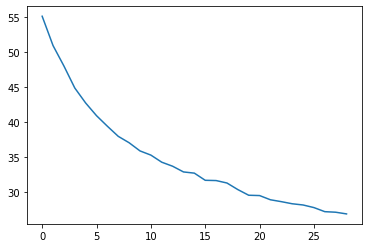

In [41]:
plt.plot([model.inertia_ for model in ModelosCluster])

In [60]:
pd.DataFrame(
    ModelosCluster[2].predict(ModeloNMF.transform(VectorTfidf)),
    index = Base500Canciones.index
)

0
0    2
1    0
2    1
3    0
4    0
..  ..
495  0
496  0
497  0
498  0
499  0

[500 rows x 1 columns]

In [72]:
(
pd.DataFrame(
    ModeloNMF.transform(VectorTfidf),
    index = Base500Canciones.index, 
    columns = ['Canciones','Declaraciones','Beatles']
)
.join(
    pd.DataFrame(
        ModelosCluster[2].predict(ModeloNMF.transform(VectorTfidf)),
        index = Base500Canciones.index, columns = ['Grupo'])
    .assign(Grupo = lambda df: "G " + df.Grupo.astype(str))
)
).groupby("Grupo").mean().plot(kind='bar')

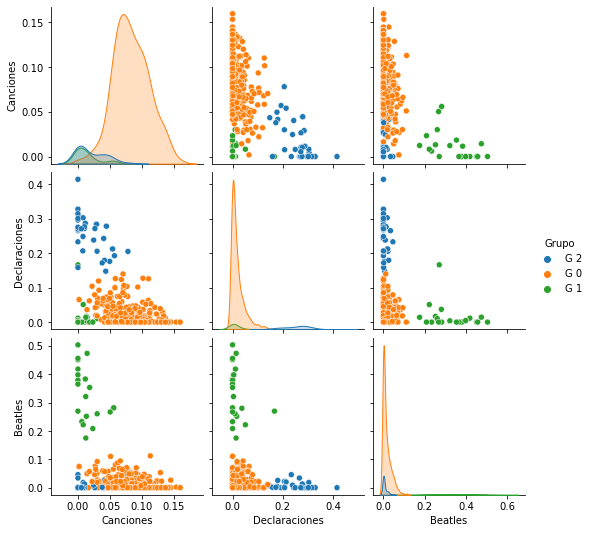

In [61]:
sns.pairplot(

    pd.DataFrame(
        ModeloNMF.transform(VectorTfidf),
        index = Base500Canciones.index, 
        columns = ['Canciones','Declaraciones','Beatles']
    )
    .join(
        pd.DataFrame(
            ModelosCluster[2].predict(ModeloNMF.transform(VectorTfidf)),
            index = Base500Canciones.index, columns = ['Grupo'])
        .assign(Grupo = lambda df: "G " + df.Grupo.astype(str))
    )
    , hue = 'Grupo'
)


In [ ]:
#Grupo 1: Canciones valoradas por su contenido
#Grupo 2: Canciones con peso de declaraciones a RS
#Grupo 3: The beatles

In [29]:
Base500Canciones['Grupo'] = pd.DataFrame(
            ModelosCluster[2].predict(ModeloNMF.transform(VectorTfidf)),
            index = Base500Canciones.index, columns = ['Grupo']).astype(str)

In [30]:
Base500Canciones.columns

Index(['title', 'description', 'appears on', 'artist', 'writers', 'producer',
       'released', 'streak', 'position', 'Fecha de Estreno',
       'description prepocess', 'description prepocess stem', 'Grupo'],
      dtype='object')

In [73]:
Base500Canciones[['title','Grupo','description']].to_excel("Segmentacion.xlsx")